In [1]:
install.packages("VGAM")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [1]:
library(VGAM)

Loading required package: stats4

Loading required package: splines



In [2]:
library(dplyr)
library(data.table)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




In [3]:
vcf_file <- "/home/dmeyer/projects/bqtls/SecondRound_bQTLs/VCF_files/bgzipped_vcfs/monocyte_pool.vcf.gz.gz"

In [4]:
cell_lines <- system(paste("bcftools query -l", vcf_file), intern = T)

In [5]:
geno = fread(cmd = paste("bcftools query -f '%CHROM\t%POS\t%REF\t%ALT\t%ID\t%AC\t%AN\t%AF[\t%GT]\n'", vcf_file), header = F, 
                  col.names = c("CHROM", "POS", "REF", "ALT", "ID", "AC", "AN", "AF", cell_lines))

In [7]:
geno_fix <- function (x) {
    switch(x,
       "0|0"=0,
       "1|0"=0.5,
       "0|1"=0.5,
       "1|1"=1, 
       "0/0"=0,
       "1/0"=0.5,
       "0/1"=0.5,
       "1/1"=1, 
           NA)
}

In [8]:
for (x in cell_lines) {
    geno[[x]] <- sapply(geno[[x]], geno_fix)
}

In [9]:
saveRDS(geno, "monocyte_pool.geno.RDS")

In [10]:
lapply(9:ncol(geno), function(x) {
    unique(geno[[x]])
})%>%
unlist%>%
unique

[1] 0.0 0.5 1.0

In [17]:
geno_flipped <- mutate(vcf_stats, AC = AN - AC, AF = 1-AF, tmp = REF, REF=ALT)%>%mutate(ALT = tmp)%>%select(-tmp)%>%
    mutate(ID = paste(CHROM, POS, REF, ALT, sep=":"))

In [11]:
obs_file <- "~/projects/bqtls/SecondRound_bQTLs/Monocytes/CEBPB_mono_allelic_out.txt"

In [12]:
obs <- fread(obs_file, sep = "\t", header = F, skip = 1) 
obs <- obs[,1:(ncol(obs)-1)]
colnames(obs) <- unlist(strsplit(readLines(obs_file, 1), "\t"))

In [13]:
nrow(obs[totalCount >= 100])

[1] 1626

In [14]:
if (!all(obs$variantID %in% geno$ID)) {
    stop("Allele flipping in", obs_file)
}

In [15]:
head(geno)

CHROM,POS,REF,ALT,ID,AC,AN,AF,GSA6_54_NYUMD0149-01,GSA6_8_NYUMD0179-01,⋯,GSA8_0_NYUMD0280-01,GSA8_0_NYUMD0327-01,GSA3-PD3_209_NYUMD0041-01,GSA6_19_NYUMD0189-01,GSA6_80_NYUMD0163-01,GSA7_316_NYUMD0231,GSA4_78_NYUMD0087,GSA6_13_NYUMD0156-01,GSA5_16_NYUMD0075-01,GSA8_0_NYUMD0296-01
<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1,23308,G,C,chr1:23308:G:C,0,64,0.01508,0.0,0,⋯,0,0,0,0,0,0,0,0,0,0.0
chr1,409458,T,TTATTTA,chr1:409458:T:TTATTTA,2,64,0.00947,0.5,0,⋯,0,0,0,0,0,0,0,0,0,0.0
chr1,595259,G,A,chr1:595259:G:A,0,64,0.01915,0.0,0,⋯,0,0,0,0,0,0,0,0,0,0.0
chr1,701203,G,T,chr1:701203:G:T,2,64,0.00843,0.0,0,⋯,0,0,0,0,0,0,0,0,0,0.5
chr1,708118,TCAC,T,chr1:708118:TCAC:T,1,64,0.00544,0.0,0,⋯,0,0,0,0,0,0,0,0,0,0.0
chr1,708216,T,C,chr1:708216:T:C,1,64,0.00679,0.0,0,⋯,0,0,0,0,0,0,0,0,0,0.0


## Do deconvolution

I believe that it works in the following way:
1. We learn representations of cell lines from CHIP seq variant abundances (learn mixing ratios that best estimate final allele counts)
2. We use this learned representation vector to estimate new AFs
3. We look for variants that are skewed in some unexpected way

In [119]:
obs_sub <- obs[totalCount >= 100]
variants_keep <- geno[(AC / AN) >= 0.05 & ID %in% obs_sub$variantID]$ID
obs_sub <- obs_sub[match(variants_keep, variantID)]
geno_sub <- geno[match(variants_keep, ID)]

In [120]:
X <- as.matrix(geno[match(variants_keep, ID), ..cell_lines])
dim(X)

[1] 899  32

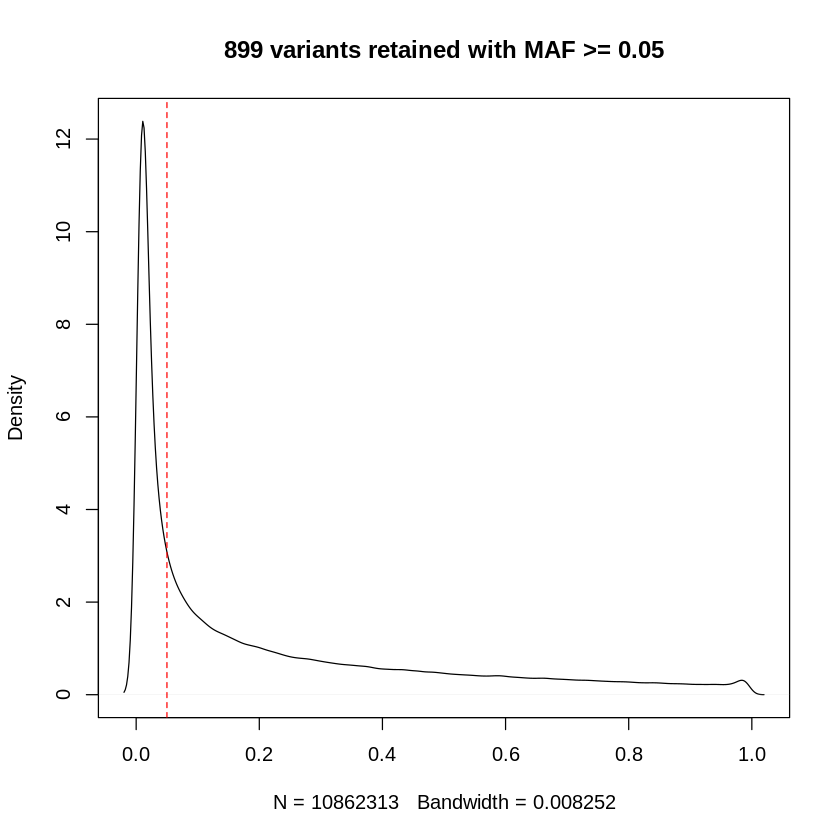

In [55]:
plot(density(geno$AF), main = paste(nrow(X), "variants retained with MAF >= 0.05"))
abline(v=0.05, col='red', lty='dashed')

In [56]:
# observed allelic ratios
y <- with(obs_sub, altCount / totalCount)
length(y)

[1] 899

In [57]:
library(ggplot2)

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 1 rows containing missing values (`geom_bar()`).”


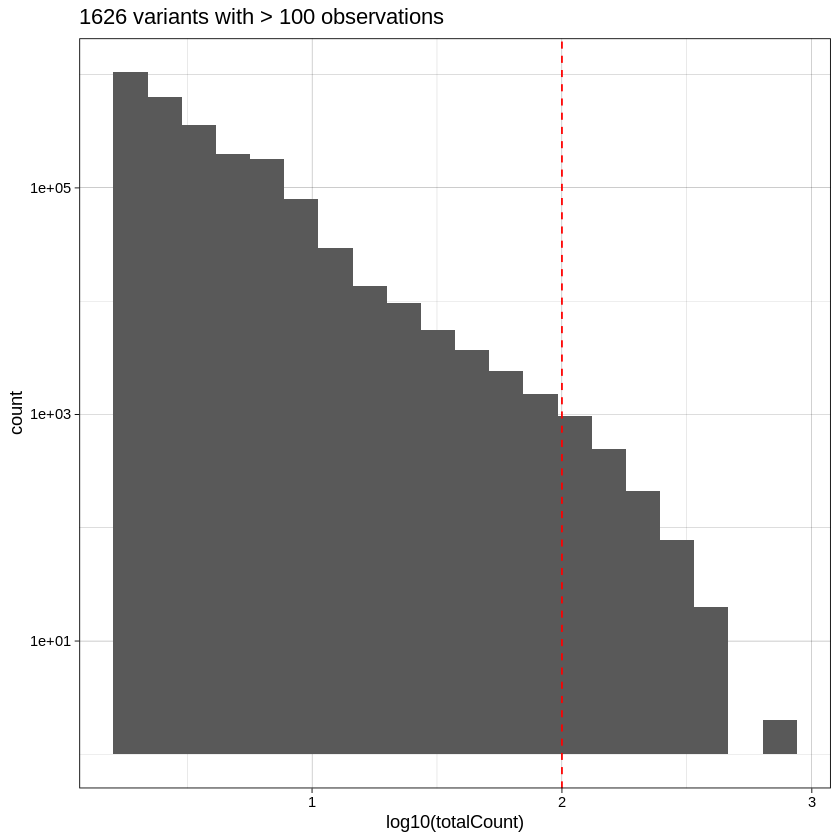

In [58]:
ggplot(obs, aes(x = log10(totalCount))) +  theme_linedraw()+
geom_histogram(bins = 20) +
scale_y_log10()+
geom_vline(xintercept = log10(100), col='red', lty='dashed')+
labs(title = nrow(obs[totalCount >= 100])%>%paste("variants with > 100 observations"))

In [59]:
stopifnot(all(!is.na(y)))
stopifnot(all(is.numeric(y)))

In [60]:
fit <- lm(y ~ 0+X)

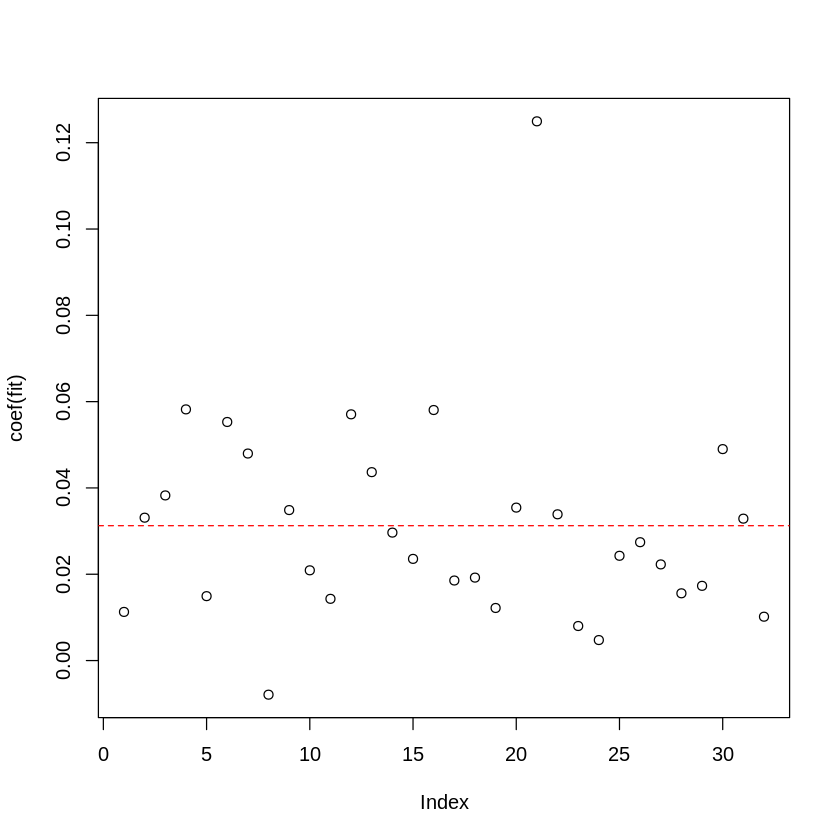

In [61]:
plot(coef(fit))
abline(h = 1/length(cell_lines), col = 'red', lty='dashed')

In [62]:
w <- coef(fit)
stopifnot(all(paste0('X', cell_lines) == names(w)))
names(w) <- cell_lines

In [121]:
afs_expected <- with(geno_sub,AC / AN)

In [80]:
# Multiply each row of X by w and sum to get predicted AFs
# so  X %*% x
mu = X  %*% w

In [83]:
min(mu)
max(mu)

[1] 0.02597304

[1] 0.9890848

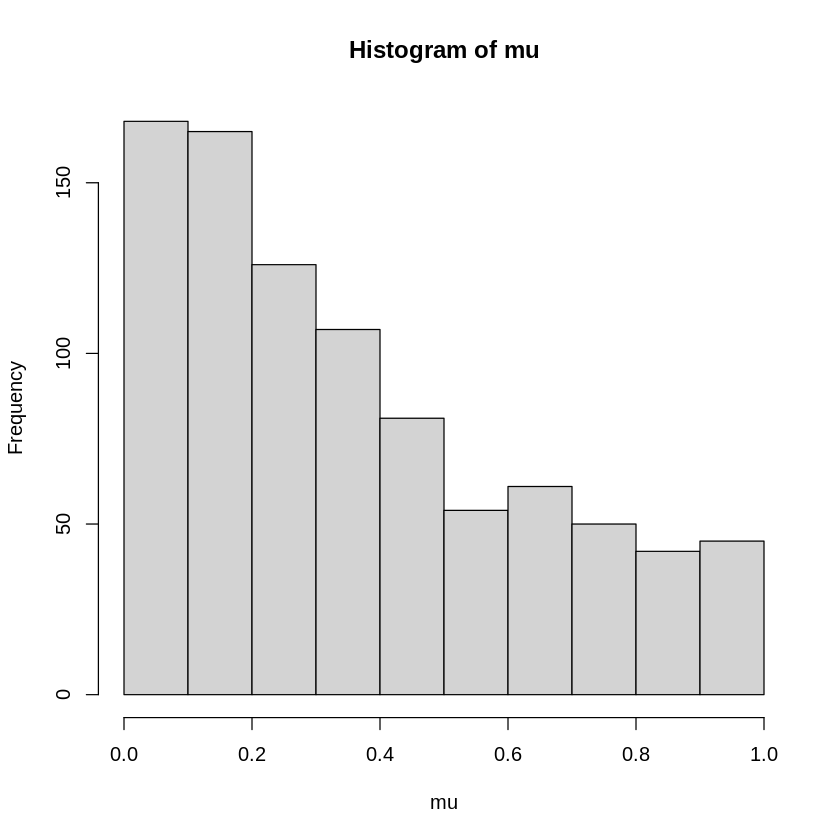

In [85]:
hist(mu)

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


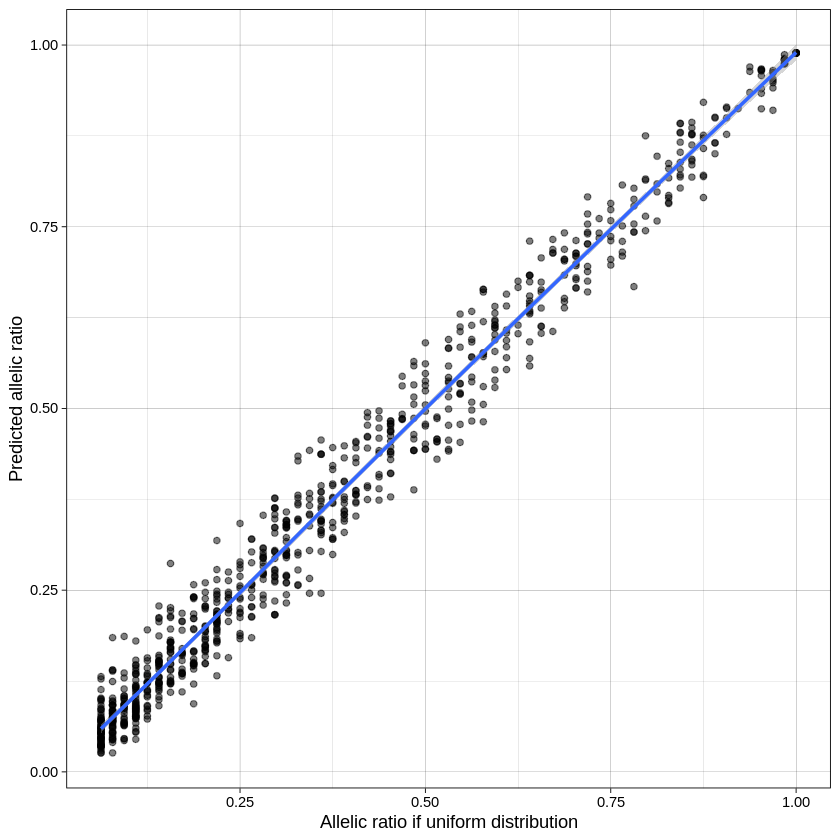

In [111]:
data.frame(mu, afs_expected)%>%
ggplot(aes(x = afs_expected, y = mu)) + 
geom_point(alpha = 0.5) +
theme_linedraw()+
geom_smooth()+
labs(x = "Allelic ratio if uniform distribution", y = "Predicted allelic ratio")

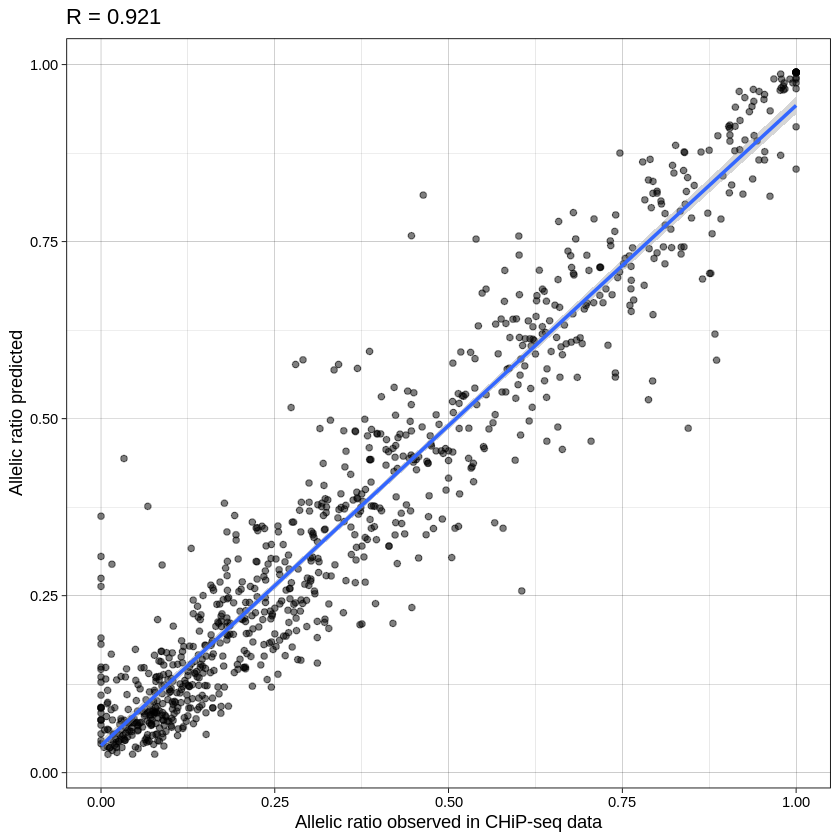

In [117]:
# Then we also want to plot predicted allelic ratio against ACTUAL allelic ratio
observed_allelic_ratio <- obs_sub$altCount / obs_sub$totalCount

ggplot(data.frame(observed_allelic_ratio, predicted_allelic_ratio = mu),
       aes(x = observed_allelic_ratio, y = mu)) +
geom_point(alpha = 0.5) +
geom_smooth(method=lm, formula = y ~ x, se = TRUE) +
theme_linedraw()+
labs(x = "Allelic ratio observed in CHiP-seq data", y = "Allelic ratio predicted", title = paste0("R = ", formatC(cor(observed_allelic_ratio, mu)^2, digits = 3)))

## Then run beta model

In [171]:
fit <- vglm( cbind(AC, AN-AC) ~ logitlink(offset(mu)), betabinomialff, geno_sub, trace = TRUE, crit = "coef")

VGLM    linear loop  1 :  coefficients = 
-0.16056817, -0.23754073, -0.23627732, -0.97913993
VGLM    linear loop  2 :  coefficients = 
 0.9707786926,  1.0974855154, -0.0052025244, -0.7957655356
VGLM    linear loop  3 :  coefficients = 
 2.0711634472,  2.1360263621,  0.0095945812, -0.8804484793
VGLM    linear loop  4 :  coefficients = 
 3.283645053,  3.310542926, -0.091809792, -1.019519668
VGLM    linear loop  5 :  coefficients = 
 4.8865789,  4.9013712, -0.3794222, -1.3222212
VGLM    linear loop  6 :  coefficients = 
 8.2135853,  8.2220020, -1.2026106, -2.1545954
Applying Greenstadt modification to 170 matrices
VGLM    linear loop  7 :  coefficients = 
17.7354462, 17.7395677, -3.4655738, -4.4224819


Warning message in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon):
“522 diagonal elements of the working weights variable 'wz' have been replaced by 1.819e-12”


Applying Greenstadt modification to 438 matrices
VGLM    linear loop  8 :  coefficients = 
17.7354462, 17.7395677, -3.4655738, -4.4224819


In [ ]:
saveRDS(fit, "2023-09-21_beta_fit")

In [172]:
summary(fit)


Call:
vglm(formula = cbind(AC, AN - AC) ~ logitlink(offset(mu)), family = betabinomialff, 
    data = geno_sub, trace = TRUE, crit = "coef")

Coefficients: 
                          Estimate Std. Error  z value Pr(>|z|)    
(Intercept):1            1.774e+01  5.503e-05   322292   <2e-16 ***
(Intercept):2            1.774e+01  1.265e-05  1402680   <2e-16 ***
logitlink(offset(mu)):1 -3.466e+00  1.636e-05  -211781   <2e-16 ***
logitlink(offset(mu)):2 -4.422e+00  3.723e-06 -1187936   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Names of linear predictors: loglink(shape1), loglink(shape2)

Log-likelihood: -2052.832 on 1794 degrees of freedom

Number of Fisher scoring iterations: 8 

No Hauck-Donner effect found in any of the estimates


In [175]:
terms(fit)

cbind(AC, AN - AC) ~ logitlink(offset(mu))
attr(,"variables")
list(cbind(AC, AN - AC), logitlink(offset(mu)))
attr(,"factors")
                      logitlink(offset(mu))
cbind(AC, AN - AC)                        0
logitlink(offset(mu))                     1
attr(,"term.labels")
[1] "logitlink(offset(mu))"
attr(,"order")
[1] 1
attr(,"intercept")
[1] 1
attr(,"response")
[1] 1
attr(,".Environment")
<environment: R_GlobalEnv>
attr(,"predvars")
list(cbind(AC, AN - AC), logitlink(offset(mu)))
attr(,"dataClasses")
   cbind(AC, AN - AC) logitlink(offset(mu)) 
          "nmatrix.2"           "nmatrix.1" 

In [145]:
coef(fit)

(Intercept):1         (Intercept):2 logitoffsetlink(mu):1 
            17.735446             17.739568             -3.465574 
logitoffsetlink(mu):2 
            -4.422482

In [176]:
coef(fit, matrix = TRUE)

,loglink(shape1),loglink(shape2)
(Intercept),17.735446,17.739568
logitlink(offset(mu)),-3.465574,-4.422482


In [177]:
Coef(fit)

(Intercept):1           (Intercept):2 logitlink(offset(mu)):1 
              17.735446               17.739568               -3.465574 
logitlink(offset(mu)):2 
              -4.422482

In [179]:
length(fit@misc$rho)  # The correlation parameter

[1] 899

In [180]:
t(fitted(fit))

0.9649616,0.375938,0.7774418,0.8684072,0.08942117,0.2789001,0.6342442,0.2250703,0.2356924,0.2356924,⋯,0.9867224,0.7305014,0.4337572,0.443713,0.443713,0.443713,0.5265016,0.2409073,0.731758,0.1452518


In [188]:
t(depvar(fit))

1,2,3,4,5,6,7,8,9,10,⋯,890,891,892,893,894,895,896,897,898,899
0.9375,0.40625,0.78125,0.859375,0.109375,0.28125,0.609375,0.21875,0.265625,0.265625,⋯,1,0.71875,0.40625,0.484375,0.484375,0.484375,0.59375,0.3125,0.734375,0.09375


In [182]:
t(weights(fit, type = "prior"))

1,2,3,4,5,6,7,8,9,10,⋯,890,891,892,893,894,895,896,897,898,899
64,64,64,64,64,64,64,64,64,64,⋯,64,64,64,64,64,64,64,64,64,64


In [183]:
# A "loglink" link for the 2 shape params is a logistic regression:
all.equal(c(fitted(fit)),
          as.vector(logitlink(predict(fit)[, 1] -
                          predict(fit)[, 2], inverse = TRUE)))

[1] TRUE

In [220]:
dim(fitted(fit))

[1] 899   1

In [221]:
predict(fit)%>%dim

[1] 899   2

In [211]:
betabinomial()

Family:  betabinomial 

Beta-binomial model
Links:      logitlink(mu), logitlink(rho)
Mean:       mu
Variance:   mu*(1-mu)*(1+(w-1)*rho)/w

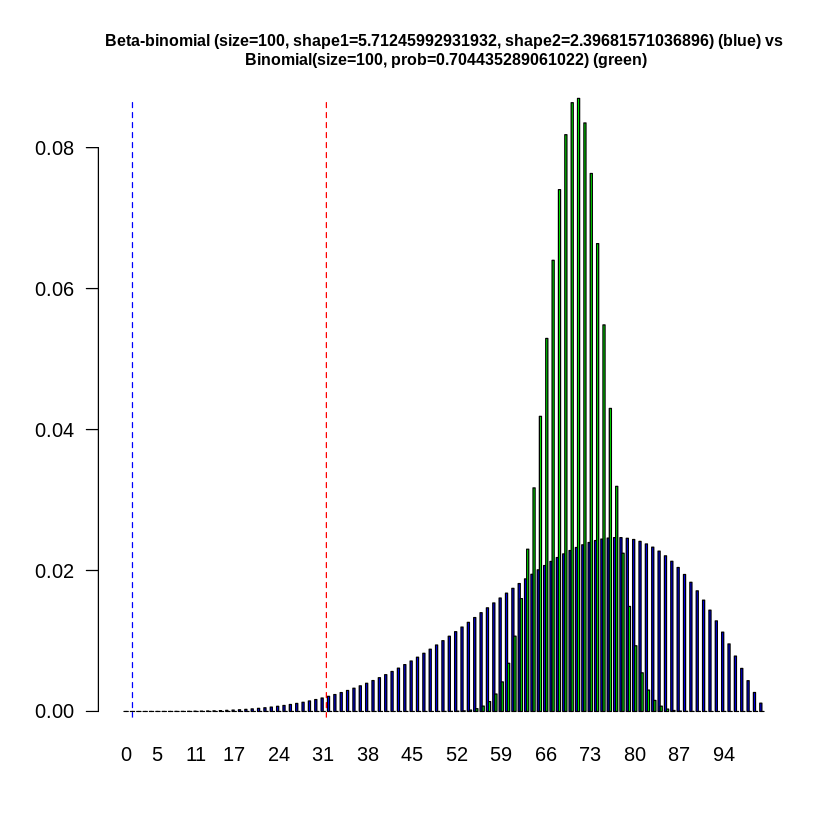

In [230]:
N <- 100; xx <- 0:N; s1 <- 2; s2 <- 3
s1 <- predict(fit)[1,1]; s2 <- predict(fit)[1,2]
mu <- fitted(fit)[1,1]*N

q_thresh <- 0.05
dy <- dbetabinom.ab(xx, size = N, shape1 = s1, shape2 = s2)
barplot(rbind(dy, dbinom(xx, size = N, prob = s1 / (s1+s2))),
        beside = TRUE, col = c("blue","green"), las = 1,
        main = paste("Beta-binomial (size=",N,", shape1=", s1,
                   ", shape2=", s2, ") (blue) vs\n",
        " Binomial(size=", N, ", prob=", s1/(s1+s2), ") (green)",
                     sep = ""),
        names.arg = as.character(xx), cex.main = 0.8)
abline(v=mu, col='red', lty='dashed')
abline(v=q_thresh * N, col='blue', lty='dashed')

In [231]:
cdf(fit)

ERROR: Error in cdf.betabinomialff(object, newdata, ...): could not find function "cdf.betabinomialff"


In [234]:
x

[1] "GSA8_0_NYUMD0296-01"

In [237]:
cdf(dbetabinom.ab(, shape1 = s1, shape2 = s2))

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'object' in selecting a method for function 'cdf': argument "size" is missing, with no default


In [244]:
cbind(residuals(fit), predict(fit))

,loglink(shape1),loglink(shape2),loglink(shape1),loglink(shape2)
1,2.398371e+00,3.210308e+00,5.712460,2.396816
2,6.410872e-02,-3.861942e-02,19.556057,20.062883
3,1.892649e+00,1.870640e+00,13.190503,11.939683
4,1.409001e+03,1.409080e+03,10.886677,8.999729
5,2.450205e-01,-2.464249e-01,26.125336,28.446059
6,2.047517e-03,-7.919442e-04,21.160801,22.110725
7,-6.341813e-02,4.378774e-02,15.726924,15.176456
8,-2.216942e-04,6.438461e-05,22.198166,23.434526
9,1.440289e-03,-4.441518e-04,21.981169,23.157611
10,1.440289e-03,-4.441518e-04,21.981169,23.157611


In [248]:
cdf(fit)

ERROR: Error in cdf.betabinomialff(object, newdata, ...): could not find function "cdf.betabinomialff"


[1] 0.1987

[1] 0.22115

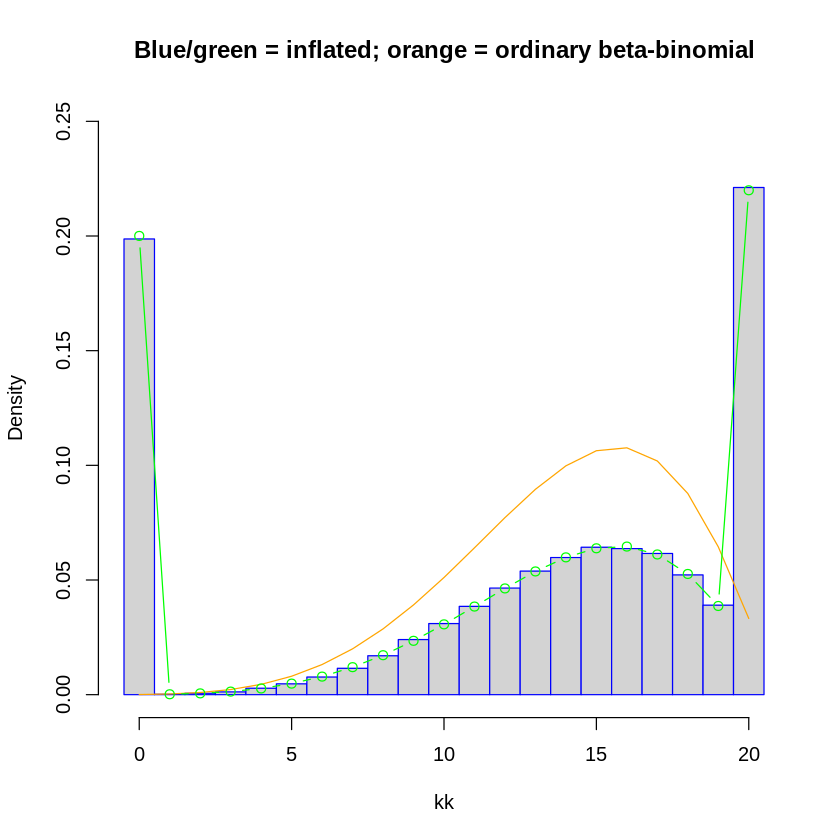

In [238]:
N <- 1e5; size <- 20; pstr0 <- 0.2; pstrsize <- 0.2
kk <- rzoibetabinom.ab(N, size, s1, s2, pstr0, pstrsize)
hist(kk, probability = TRUE, border = "blue", ylim = c(0, 0.25),
     main = "Blue/green = inflated; orange = ordinary beta-binomial",
     breaks = -0.5 : (size + 0.5))
sum(kk == 0) / N  # Proportion of 0
sum(kk == size) / N  # Proportion of size
lines(0 : size,
      dbetabinom.ab(0 : size, size, s1, s2), col = "orange")
lines(0 : size, col = "green", type = "b",
      dzoibetabinom.ab(0 : size, size, s1, s2, pstr0, pstrsize))
